# Running on new images
This notebook will walk you step by step through the process of using a pre-trained model to detect traffic signs in an image.

# Imports

In [38]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import os
import tensorflow as tf

tf.enable_eager_execution()


from matplotlib import pyplot as plt
from PIL import Image
import glob as glob
import random
import pickle

%matplotlib inline

In [39]:
tf.executing_eagerly()

True

# Environment setup

In [40]:

import sys

sys.path.append('../models/research')  # Replace with the path to TensorFlow Object Detection API
sys.path.append('../darkflow')  # Replace with the path to Darkflow

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util


# Tensorflow Object Detection API

## Model preparation 

In [41]:
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'

In [42]:
# Path to frozen detection graph. This is the actual model that is used for the traffic sign detection.
MODEL_PATH = os.path.join('models', MODEL_NAME)
PATH_TO_CKPT = os.path.join(MODEL_PATH,'inference_graph/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('gtsdb_data', 'gtsdb3_label_map.pbtxt')

NUM_CLASSES = 3


## Load a (frozen) Tensorflow model into memory

In [43]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `2`, we know that this corresponds to `mandatory`.

In [44]:
PATH_TO_LABELS = '/home/yuxing/my_project/traffic-sign-detection/gtsdb_data/gtsdb3_label_map.pbtxt'

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)


item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



## Helper code

In [45]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## Detection

In [46]:

PATH_TO_TEST_IMAGES_DIR = '/home/yuxing/my_project/traffic-sign-detection/test_images'

TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

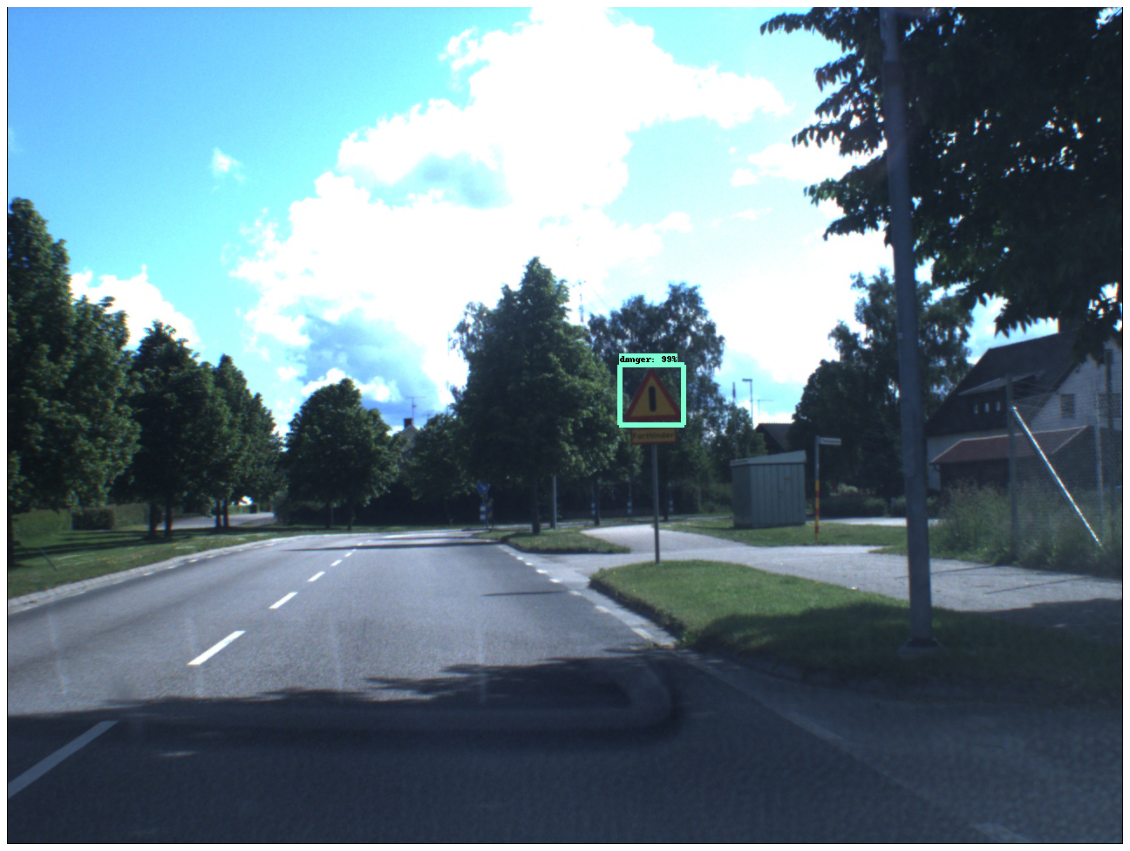

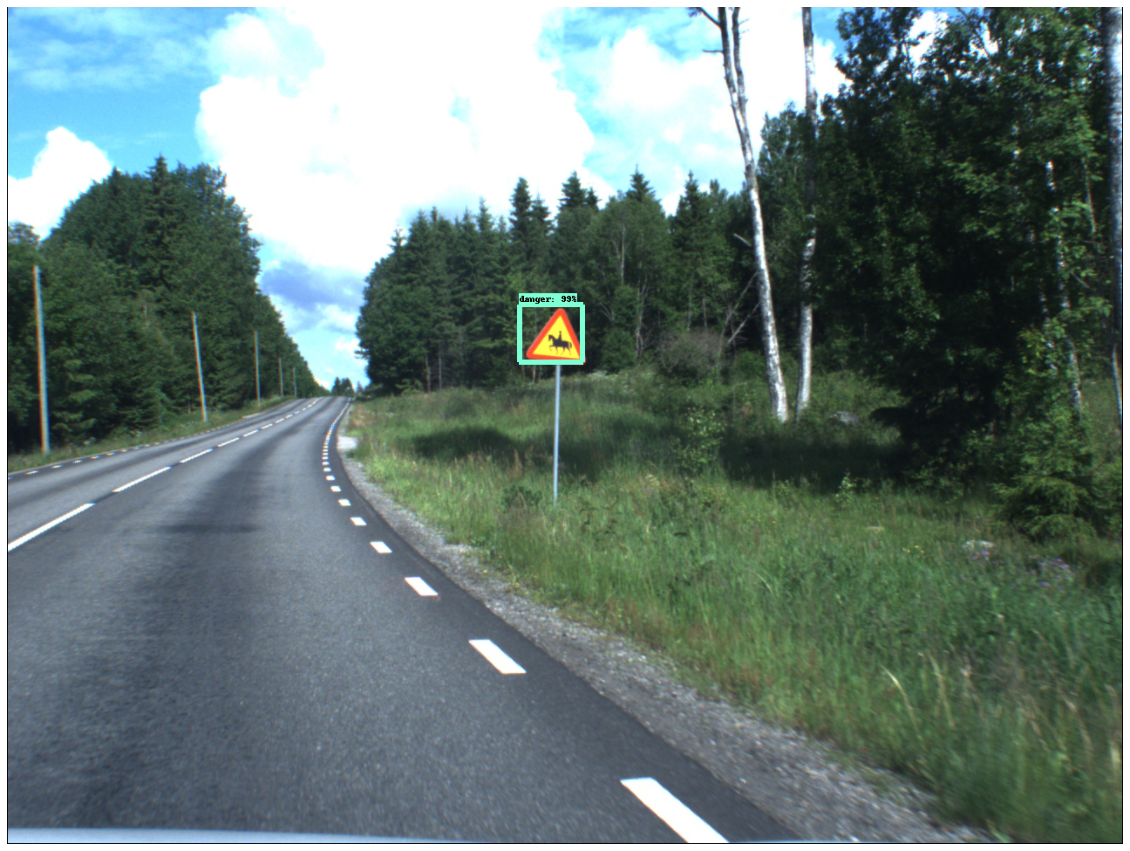

In [47]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            plt.imshow(image_np)


In [50]:

def perform_inference(sess, image_tensor, image_np_expanded, boxes, scores, classes, num_detections):
    return sess.run([boxes, scores, classes, num_detections], 
                    feed_dict={image_tensor: image_np_expanded})

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        with detection_graph.as_default():
            with tf.Session(graph=detection_graph) as sess:
                image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
                scores = detection_graph.get_tensor_by_name('detection_scores:0')
                classes = detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name('num_detections:0')
                prediction = perform_inference(sess, image_tensor, input_image, boxes, scores, classes, num_detections)
        
        loss = loss_object(input_label, prediction[1]) 
    
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

        print("Information for image_tensor")
        print(type(image_tensor))
        print(image_tensor.shape)
        print(image_tensor.dtype)
        
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(image_path)
            image_np = np.array(image).astype(np.uint8)
            
            # Expand dimensions
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # Convert to TensorFlow tensor
            image_np_expanded_tf = image_np_expanded.astype(np.float32)
            image_np_expanded_tf = tf.convert_to_tensor(image_np_expanded_tf)
            
            image_np_expanded_numpy = sess.run(image_np_expanded_tf)
            
            # Convert the type to uint8
            image_np_expanded_numpy = image_np_expanded_numpy.astype(np.uint8)
            
            # Now use this NumPy array in the feed_dict
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded_numpy})
        
            # Choose the detection with the highest score
            max_score_idx = np.argmax(scores)
            target_class = int(classes[0, max_score_idx])
            
            # Create the one-hot label for the class
            label = tf.one_hot(target_class, NUM_CLASSES)
            label = tf.reshape(label, (1, NUM_CLASSES))

            # # Convert the NumPy array back to a TensorFlow tensor
            # input_image = tf.convert_to_tensor(image_np_expanded_numpy.astype(np.float32))

            # Generate the adversarial example
            perturbations = create_adversarial_pattern(input_image, label)

            
            # Create adversarial image
            eps = 0.1  # You can vary this
            adv_x = image_np + eps * perturbations
            adv_x = np.clip(adv_x, 0, 255).astype(np.uint8)
            
            # Run adversarial image through the model to visualize how well the attack worked
            (adv_boxes, adv_scores, adv_classes, adv_num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: np.expand_dims(adv_x, axis=0)})
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                adv_x,
                np.squeeze(adv_boxes),
                np.squeeze(adv_classes).astype(np.int32),
                np.squeeze(adv_scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            plt.imshow(adv_x)
            plt.show()





Debugging Information for image_tensor
<class 'tensorflow.python.framework.ops.Tensor'>
(?, ?, ?, 3)
<dtype: 'uint8'>


TypeError: The value of a feed cannot be a tf.Tensor object. Acceptable feed values include Python scalars, strings, lists, numpy ndarrays, or TensorHandles. For reference, the tensor object was Tensor("Const_6:0", shape=(1, 960, 1280, 3), dtype=float32) which was passed to the feed with key Tensor("image_tensor:0", shape=(?, ?, ?, 3), dtype=uint8).

In [ ]:
for op in detection_graph.get_operations():
    if 'label' in op.name.lower():
        print(op.name)
